In [24]:
#import libraries
import os as os
os.environ['USE_PYGEOS'] = '0'
import matplotlib as mpl
import osmnx as ox
import geopandas as gpd
import networkx as nx
import shapely as shply
import folium as fm
import rasterio as rio
import elevation as elev

In [25]:
#reading evacuation zone shape file
ev_zones = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/final_project/EvacuationBrochure_Data/EvacuationZones.shp')

#reading critical facilities shape file
critical_facil = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/final_project/EvacuationBrochure_Data/CriticalFacilities.shp')

#reading outsize hazards shapefile
outside_hazards = gpd.read_file('/Users/maxspiegel/Desktop/490GSDS/final_project/EvacuationBrochure_Data/OutsideHazardArea_GreenHighGround.shp')

In [26]:
outside_hazards

,FEATURE,geometry
0,3,"POLYGON ((306336.912 113513.513, 306424.202 11..."
1,3,"POLYGON ((283536.132 132016.291, 283532.141 13..."
2,3,"POLYGON ((305613.929 141552.960, 305537.927 14..."
3,3,"POLYGON ((265200.130 168308.677, 265161.723 16..."
4,3,"POLYGON ((264291.297 171165.937, 264309.395 17..."
...,...,...
453,3,"POLYGON ((432817.867 1638884.191, 432811.086 1..."
454,3,"POLYGON ((435819.917 1640273.646, 435829.004 1..."
455,3,"POLYGON ((433868.042 1643250.627, 433875.645 1..."
456,3,"POLYGON ((487275.809 1643343.292, 487277.983 1..."


<AxesSubplot: >

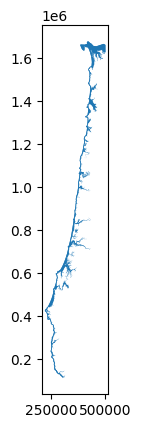

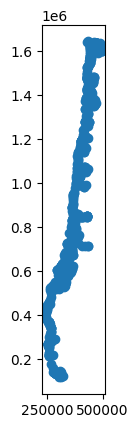

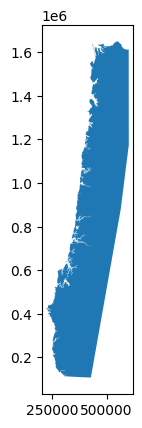

In [33]:
#checking plots
ev_zones.plot()
critical_facil.plot()
outside_hazards.plot()

<AxesSubplot: >

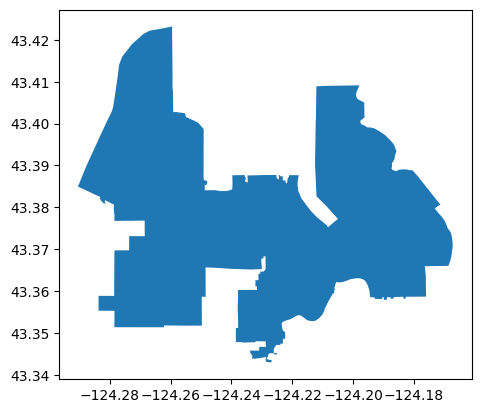

In [30]:
ox.settings.log_console=True
# define the place query for coos bay on osmnx
query = {'city': 'Coos Bay'}

# get the boundaries of the city limits
gdf_coos = ox.geocode_to_gdf(query)
gdf_coos.plot()
